In [1]:
import sys
sys.path.append("./")
sys.path.append("..")
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc  
import pandas as pd
import torch
import numpy as np
#from lib import *
import _pickle as pickle
import itertools
import statistics
import random
import statistics
from scipy.linalg import expm, sinm, cosm


####### generate states of SO(5) algebra below
m = 5     # m of so(m) algebra

list1 = np.arange(0,m)                                   # list of rows in each generator
set1 = list(set(itertools.combinations(list1, 2)))       # choose 2 axis to create plane of rotation; total m*(m-1)/2 ways
generator_list = []                                      # list to store m(m-1)/2 generators of so(m) group

for tup in set1:
    i = tup[0]                                           # index of first axis
    j = tup[1]                                           # index of second axis. i<j by construction
    generator = np.zeros((m,m))                          # create empty generator matrix
    generator[i][j] = -1.                                # since i<j , row = i, column = j eleemnt should be -1
    generator[j][i] = 1.                                 # and row = j, column = i element should be 1
    generator_list.append(generator)                     # append this generator to the list of generators
    
    
so5_list = []
for i in range(1000):                                    # we want total 1000 thousand states of so(m) algebra
    state_vec = np.zeros((m,m))
    for gen in generator_list:
        state_vec += random.random()*gen
        
    state = expm(state_vec)                # exponentiate that group element to get SO(3) algebra element
    det = np.matmul(state, np.transpose(state))
    so5_list.append(state)

path = 'so5_states_list.pickle'
with open(path, 'ab') as f :
    pickle.dump(so5_list,f)



In [2]:

#### we have states of SO(5), so let's try trobuleshooting with theory kernel at d_out = 5 

def G2_new(G, R):                          # original function for transforming rank 2 tensor elements
    Gaj = np.einsum("ai,ij->aj", R, G)     # transform first index
    Gab = np.einsum("bj,aj->ab", R,Gaj)    # transform second index
   
    return Gab

def G4_new(G, R):                                      # original function for transforming rank 4 tensor elements
    Gajkl = np.einsum("ai,ijkl->ajkl", R, G)           # transform first index
    Gabkl = np.einsum("bj,ajkl->abkl", R, Gajkl)       # transform second index
    Gabcl = np.einsum("ck,abkl->abcl", R, Gabkl)       # transform third index
    Gabcd = np.einsum("dl,abcl->abcd", R, Gabcl)       # transform fourth index
    return Gabcd


# # # # # # # # #
# width = 1000 is GP, rest are NGP 

### we load the saved so(5) list and deal with it

so5_list = []
path = 'so5_states_list.pickle'
with open(path, 'rb') as f :
    so5_list = pickle.load(f)

widthlist = [5, 10, 50, 100, 1000]

so5_dev_2pt_avg_list = []
so5_dev_2pt_std_list = []
predicted_err_2pt_avg_list = [0]*len(widthlist)
predicted_err_2pt_std_list = []

so5_dev_4pt_avg_list = []
so5_dev_4pt_std_list = []
predicted_err_4pt_avg_list = [0]*len(widthlist)
predicted_err_4pt_std_list = []

for width in widthlist:
    path_2pt_ex = '../2ptexp_dout5' + str(width) + '.pickle'
    path_4pt_ex = '../4ptexp_dout5' + str(width) + '.pickle'
    G2_background = pickle.load(open("../2ptexp_dout5" + str(width) + "stdev.pickle", "rb")) 
    G4_background = pickle.load(open("../4ptexp_dout5" + str(width) + "stdev.pickle", "rb")) 
    print("Running network at width ", width)



    G2_ex = pickle.load(open(path_2pt_ex,"rb"))     # open each theoretical rank n tensor 
    G2_ex_np = np.array(G2_ex)                      # convert theoretical n pt tensor into a numpy array

    G4_ex = pickle.load(open(path_4pt_ex,"rb"))     # open each theoretical rank n tensor 
    G4_ex_np = np.array(G4_ex)                      # convert theoretical n pt tensor into a numpy array

    n_inputs_4pt = G4_ex.shape[0]                   # number of spatial inputs
    d_out_4pt = G4_ex.shape[-1]                     # output dimension

    n_inputs_2pt = G2_ex.shape[0]                   # number of spatial inputs
    d_out_2pt = G2_ex.shape[-1]                     # output dimension


    ###### let's estimate the precision error in so5 elements
    so5_precision_list = []
    for i in range(len(so5_list)) :
        so5_element = so5_list[i]
        det_so5_ele = np.matmul(so5_element, np.transpose(so5_element))
        sum1= 0
        for a in range(d_out_2pt):                      # for each row in d_out
            for b in range(d_out_2pt):                  # and each column in d_out
                if a!=b :                               # error is estimated only from off diagonal elements being nonzero
                    for j in range(d_out_2pt) :             # find determinant element for that row, column
                        sum1 += (so5_element[j][b])**2 + (so5_element[a][j])**2   
                    x = np.abs((det_so5_ele[a][b])/np.sqrt(sum1))   # estimate uncertainty in so3 element from that row,column of det
                    so5_precision_list.append(x)            # make a list of error estimates

    avg_precision_so5_ele = statistics.mean(so5_precision_list)    # average estimated error of so(5) matrix's array elemtns
#     print("Estimate averaged numerical error in SO(5) algebar elements: ", avg_precision_so5_ele, "\n")

    G2_numerical_err = 0
    count_G2_numerical_err = 0

    G2_predict_err_list = []


    ## estimate numerical error in 2pt expt
    for xi in range(n_inputs_2pt):
        for xj in range(n_inputs_2pt):

            dev_array = G2_background[xi][xj]   # array using background levels from npt code
            for a in range(d_out_2pt):                                 # for each array element in deviation array 
                for b in range(d_out_2pt):
                    count_G2_numerical_err += 1                        # count total number of such fluctuation obervations
                    G2_numerical_err += abs(float(dev_array[a][b]))    # mean squared of each deviation array element summed around mean 0


    G2_numerical_err_avg = G2_numerical_err/count_G2_numerical_err     # standard deviation as a measure of fluctuation in expt GP 2pt fn 
#     print("Estimate avg numerical error in exp. G2 array elements: ", G2_numerical_err_avg, "\n")


    G2_so5_dev1 = 0                  # use this to calculate std
    count_G2_so5_dev1 = 0            # use this for number of observations
    G2_so5_dev = 0                   # use this to calculate mean

    for xi in range(n_inputs_2pt):                  # for each i,j in input dim
        for xj in range(n_inputs_2pt):
            G2_ex_ele = G2_ex_np[xi][xj]
            for state in so5_list :                                      # for each so(5) transformation
                G2_ex_transformed = G2_new(G2_ex_ele, state)             # G2 after SO(5) transformation

                so5_dev_array = (G2_ex_transformed - G2_ex_ele)          # deviation due to SO(5) transformation
                for a in range(d_out_2pt):                               # for each array element in the deviation array 
                    for b in range(d_out_2pt):
                        G2_so5_dev1 += (so5_dev_array[a][b])**2          # mean sqaured of each deviation array element, summed around mean 0
                        count_G2_so5_dev1 += 1                           # count the population 
                        G2_so5_dev += so5_dev_array[a][b]                # mean of each deviation array element


                for a in range(d_out_2pt):                               # for each row in d_out
                    for b in range(d_out_2pt):                           # and each column in d_out
                        Aij = 0
                        Bij = 0
                        for i in range(d_out_2pt):
                            for j in range(d_out_2pt):
                                Aij += (state[a][i]*G2_ex_ele[i][j])**2 + (state[b][j]*G2_ex_ele[i][j])**2 
                                Bij += (state[a][i]*state[b][j])**2


                        err = np.sqrt((avg_precision_so5_ele**2)*Aij + (G2_numerical_err_avg**2)*Bij )    # estimate precision error due to so(5) transformation for each element in d_outxd_out tensor
                        G2_predict_err_list.append(err)                 # stores precision error of SO(5) transform. for each element in d_out direction 

    ##### now use G2_numerical_err_avg abd avg_precision_so5_ele to predict the propagated errors in avg deviation between G2-exp before and after SO(5) tarnsformations
#     print("Use above two to predict the propagated error in exp. G2 array elements after SO(5) transformation \n")

    G2_predict_err_std = statistics.mean(G2_predict_err_list)
#     print("Predicted uncertainty in G2 due to SO(5) transformations, avg-ed over d_out, SO(5) algebra elements: ", G2_predict_err_std, "\n")
    G2_so5_dev_std = np.sqrt(G2_so5_dev1/count_G2_so5_dev1)
#     print("STD of deviation in G2 due to SO(5) transformations", G2_so5_dev_std, "\n")
    G2_so5_dev_actualmean = G2_so5_dev/count_G2_so5_dev1
#     print("Avg of deviation in G2 due to SO(5) transformations", G2_so5_dev_actualmean, "\n")

    so5_dev_2pt_avg_list.append(G2_so5_dev_actualmean)
    so5_dev_2pt_std_list.append(G2_so5_dev_std)
    predicted_err_2pt_std_list.append(G2_predict_err_std)


    #### let's test the 4pt so(5) propagated error prediction against actual error in so(5) of 4pt fn

    G4_numerical_err = 0         
    count_G4_numerical_err = 0 

    G4_so5_dev1 = 0              # for calculating std
    count_G4_so5_dev1 = 0        # for counting population
    G4_so5_dev = 0               # for calculating mean
    G4_predict_err_list = []


    for xi in range(n_inputs_4pt):
        for xj in range(n_inputs_4pt):
            for xk in range(n_inputs_4pt):
                for xl in range(n_inputs_4pt):
                    G4_thex_dev = G4_background[xi][xj][xk][xl]
                    for a in range(d_out_4pt):                               # each array element in deviation array 
                        for b in range(d_out_4pt):   
                            for c in range(d_out_4pt):                               
                                for d in range(d_out_4pt): 
                                    G4_numerical_err += abs(G4_thex_dev[a][b][c][d])    # mean squared of each deviation array element summed around mean 0
                                    count_G4_numerical_err += 1                         # count total number of such fluctuation obervations


    # print(G4_numerical_err, count_G4_numerical_err)
    G4_numerical_err_avg = G4_numerical_err/count_G4_numerical_err
#     print("Estimate avg numerical error in exp. G4 array elements: ", G4_numerical_err_avg, "\n")


    #### use the above to predict the propagated error due to SO(5) transformation in G4, at 0,0,0,0 input space indices

    G4_ex_ele = G4_ex_np[1][1][1][1]                                  # G4 exp at GP

    for state in so5_list :                                           # for each so(5) transformation

        G4_ex_transformed = G4_new(G4_ex_ele, state)                  # G2 after SO(5) transformation
        G4_so5_dev_array = (G4_ex_transformed - G4_ex_ele)            # averaged deviation due to SO(5) transformations    
       
        for a in range(d_out_4pt):                                    # each array element in deviation array 
            for b in range(d_out_4pt):   
                for c in range(d_out_4pt):                               
                    for d in range(d_out_4pt): 
                        G4_so5_dev1 += (G4_so5_dev_array[a][b][c][d])**2    # mean squared of each deviation array element summed around mean 0
                        count_G4_so5_dev1 += 1                              # count total number of such fluctuation obervations
                        G4_so5_dev += G4_so5_dev_array[a][b][c][d]          # mean of each deviation array element 



        for a in range(d_out_4pt):                                    # each array index runs from 1 to d_out
            for b in range(d_out_4pt):   
                for c in range(d_out_4pt):                               
                    for d in range(d_out_4pt):   
                        Aijkl = 0
                        Bijkl = 0
                        for i in range(d_out_4pt):
                            for j in range(d_out_4pt):
                                for k in range(d_out_4pt):
                                    for l in range(d_out_4pt):
                                        Aijkl += (state[a][i]*state[b][j]*state[c][k]*G4_ex_ele[i][j][k][l])**2 
                                        Aijkl += (state[a][i]*state[b][j]*state[d][l]*G4_ex_ele[i][j][k][l])**2 
                                        Aijkl += (state[a][i]*state[c][k]*state[d][l]*G4_ex_ele[i][j][k][l])**2 
                                        Aijkl += (state[d][l]*state[b][j]*state[c][k]*G4_ex_ele[i][j][k][l])**2 
                                        Bijkl += (state[a][i]*state[b][j]*state[c][k]*state[d][l])**2

    
                        err = np.sqrt((avg_precision_so5_ele**2)*Aijkl + (G4_numerical_err_avg**2)*Bijkl )    # estimate precision error due to so(5) transformation for each element in d_outxd_out tensor
                        G4_predict_err_list.append(err)              # stores precision error of SO(5) transform. for each element in d_out direction 


#     print("Use above two to predict the propagated error in exp. G4 array elements after SO(5) transformation \n")

    G4_predict_err_std = statistics.mean(G4_predict_err_list)
#     print("Predicted uncertainty in G4 due to SO(5) transformations, avg-ed over d_out, SO(5) algebra elements: ", G4_predict_err_std, "\n")
    G4_so5_dev_std = np.sqrt(G4_so5_dev1/count_G4_so5_dev1)
#     print("STD of deviation in G4 due to SO(5) transformations", G4_so5_dev_std, "\n")
    G4_so5_dev_actualmean = G4_so5_dev/count_G4_so5_dev1
#     print("AVG of deviation in G4 due to SO(5) transformations", G4_so5_dev_actualmean, "\n")
    
    
    so5_dev_4pt_avg_list.append(G4_so5_dev_actualmean)
    so5_dev_4pt_std_list.append(G4_so5_dev_std)
    predicted_err_4pt_std_list.append(G4_predict_err_std)

    
    
print("with actual so(5) elements")
print("widths", widthlist, "\n")
print("mean of so(5) deviations of 2pt fn", so5_dev_2pt_avg_list, "\n")
print("std of so(5) deviations of 2pt fn", so5_dev_2pt_std_list, "\n")
print("predicted error bound std of 2pt fn", predicted_err_2pt_std_list, "\n")

print("mean of so(5) deviations of 4pt fn", so5_dev_4pt_avg_list, "\n")
print("std of so(5) deviations of 4pt fn", so5_dev_4pt_std_list, "\n")
print("predicted error bound std of 4pt fn", predicted_err_4pt_std_list, "\n")


FileNotFoundError: [Errno 2] No such file or directory: '../2ptexp_dout55stdev.pickle'

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc  
import datetime

df = pd.DataFrame({"width_real": widthlist, "2pt_mean": so5_dev_2pt_avg_list, "2pt_std": so5_dev_2pt_std_list, "2pt_prop_so5": predicted_err_2pt_std_list, 
                    "4pt_mean": so5_dev_4pt_avg_list, "4pt_std": so5_dev_4pt_std_list, 
                   "4pt_prop_so5": predicted_err_4pt_std_list})


df['width'] = np.log10(df['width_real'])

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize = 20
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rc('font', size=fsize)  # controls default text sizes
plt.rc('axes', titlesize=20)  # fontsize of the axes title
plt.rc('axes', labelsize=20)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)  # fontsize of the tick labels
plt.rc('ytick', labelsize=18)  # fontsize of the tick labels
plt.rc('legend', fontsize=14)  # legend fontsize
plt.rc('figure', titlesize=fsize)  # fontsize of the figure title

sns.set_style("ticks", {"xtick.major.size":18,
"ytick.major.size":18})
def lt(s):
    return (r'$\mathrm{' + s + r'}$').replace(" ", "\,\,")

def lm(s):
    return r'$' + s + r'$'



In [ ]:
### calculate prediction bound in measure, using propagated error in G_transformed

import sys
sys.path.append("./")
sys.path.append("..")
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc  
import pandas as pd
import torch
import numpy as np
import math
#from lib import *
import _pickle as pickle
import statistics
import random
import statistics
from scipy.linalg import expm, sinm, cosm

widthlist = [5, 10, 50, 100, 1000]
deltaG2list = []
deltaG4list = []

deltaG2transformedlist = list(df["2pt_prop_so5"])
deltaG4transformedlist = list(df["4pt_prop_so5"])


for width in widthlist:
    path_2pt_ex = 'twoptexp_dout5' + str(width) + '.pickle'
    path_4pt_ex = 'fourptexp_dout5' + str(width) + '.pickle'
    G2_background = pickle.load(open("twoptexp_dout5" + str(width) + "stdev.pickle", "rb")) 
    G4_background = pickle.load(open("fourptexp_dout5" + str(width) + "stdev.pickle", "rb")) 
    print("Running network at width ", width)


    G2_ex = pickle.load(open(path_2pt_ex,"rb"))     # open each theoretical rank n tensor 
    G2_ex_np = np.array(G2_ex)                      # convert theoretical n pt tensor into a numpy array

    G4_ex = pickle.load(open(path_4pt_ex,"rb"))     # open each theoretical rank n tensor 
    G4_ex_np = np.array(G4_ex)                      # convert theoretical n pt tensor into a numpy array
    
    n_inputs_4pt = G4_ex.shape[0]                   # number of spatial inputs
    d_out_4pt = G4_ex.shape[-1]                     # output dimension

    n_inputs_2pt = G2_ex.shape[0]                   # number of spatial inputs
    d_out_2pt = G2_ex.shape[-1]                     # output dimension
    
    G2_numerical_err = 0
    count_G2_numerical_err = 0
    
    ###### estimate numerical error in 2pt expt
    for xi in range(n_inputs_2pt):
        for xj in range(n_inputs_2pt):
            dev_array = G2_background[xi][xj]                          # array using background levels from npt code
            for a in range(d_out_2pt):                                 # for each array element in deviation array 
                for b in range(d_out_2pt):
                    count_G2_numerical_err += 1                        # count total number of such fluctuation obervations
                    G2_numerical_err += abs(float(dev_array[a][b]))    # mean squared of each deviation array element summed around mean 0


    G2_numerical_err_avg = G2_numerical_err/count_G2_numerical_err     # standard deviation as a measure of fluctuation in expt GP 2pt fn 
#     print("Estimate avg numerical error in exp. G2 array elements: ", G2_numerical_err_avg, "\n")
    deltaG2list.append(G2_numerical_err_avg)
    
    G4_numerical_err = 0         
    count_G4_numerical_err = 0 
    
    for xi in range(n_inputs_4pt):
        for xj in range(n_inputs_4pt):
            for xk in range(n_inputs_4pt):
                for xl in range(n_inputs_4pt):
                    G4_thex_dev = G4_background[xi][xj][xk][xl]
                    for a in range(d_out_4pt):                               # each array element in deviation array 
                        for b in range(d_out_4pt):   
                            for c in range(d_out_4pt):                               
                                for d in range(d_out_4pt): 
                                    G4_numerical_err += abs(G4_thex_dev[a][b][c][d])    # mean squared of each deviation array element summed around mean 0
                                    count_G4_numerical_err += 1                         # count total number of such fluctuation obervations


    G4_numerical_err_avg = G4_numerical_err/count_G4_numerical_err
#     print("Estimate avg numerical error in exp. G4 array elements: ", G4_numerical_err_avg, "\n")
    deltaG4list.append(G4_numerical_err_avg)

 
deltaM2 = [np.sqrt((deltaG2list[i])**2 + (deltaG2transformedlist[i])**2)  for i in range(len(deltaG2list))  ]
deltaM4 = [np.sqrt((deltaG4list[i])**2 + (deltaG4transformedlist[i])**2)  for i in range(len(deltaG4list))  ]
df["deltaM2"] = deltaM2
df["deltaM4"] = deltaM4

print("delta G2", deltaG2list)
print("delta G4", deltaG4list)
print("delta G2 transformed", deltaG2transformedlist)
print("delta M2", deltaM2)
print("delta G4 transformed", deltaG4transformedlist)
print("delta M4", deltaM4)


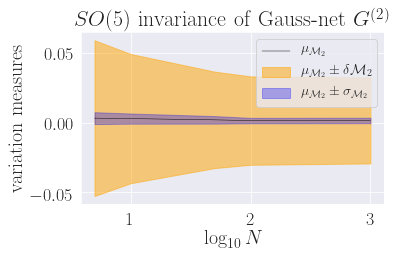

In [21]:
# 2pt plot

title_size, label_size, tick_size = 22,20,18
sns.set_style(style="darkgrid")

m = sns.lineplot(data=df,x='width',y='2pt_mean', label = lm("$\mu_{\mathcal{M}_2}$"), color="black", alpha=1, linewidth=0.45)

error1 = df["2pt_mean"]-df["2pt_std"]
error2 = df["2pt_mean"]+df["2pt_std"]
properror1 =df["2pt_mean"] -df["deltaM2"]
properror2 = df["2pt_mean"]+df["deltaM2"]

m.fill_between(df["width"], properror1, properror2, color="orange", alpha=0.5, label=lm("\mu_{\mathcal{M}_2} \pm \delta\mathcal{M}_2"))
m.fill_between(df["width"], error1, error2, color="blue", alpha=0.3, label=lm("\mu_{\mathcal{M}_2} \pm \sigma_{\mathcal{M}_2}"))


plt.tick_params(labelsize=tick_size)
plt.title(lm("SO(5)")+lt(" invariance of Gauss\\text{-}net ")+lm("G^{(2)}"),fontsize=title_size)
plt.legend(loc='upper right', borderpad=0.5,prop={'size': 14})
# plt.yscale('symlog')
plt.ylabel(lt("variation measures"),fontsize=label_size)
plt.xlabel(lm("\\log_{10}N"),fontsize=label_size)
plt.tight_layout()
plt.savefig("SO5G2.pdf", dpi = 2000)
plt.legend()
plt.show()

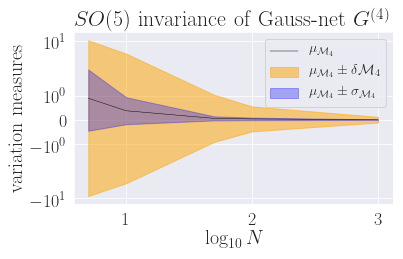

In [20]:
# 4pt plot
# print(df['4pt_rand_mean'])

title_size, label_size, tick_size = 22,20,18
sns.set_style(style="darkgrid")
m = sns.lineplot(data=df,x='width',y='4pt_mean', label = lm("$\mu_{\mathcal{M}_4}$"), color="black", alpha=1, linewidth=0.45)

error1 = df["4pt_mean"]-df["4pt_std"]
error2 = df["4pt_mean"]+df["4pt_std"]
properror1 = df["4pt_mean"]-df["deltaM4"]
properror2 = df["4pt_mean"]+df["deltaM4"]


m.fill_between(df["width"], properror1, properror2, color="orange", alpha=0.5, label=lm("\mu_{\mathcal{M}_4} \pm \delta\mathcal{M}_4"))
m.fill_between(df["width"], error1, error2, color="blue", alpha=0.3, label=lm("\mu_{\mathcal{M}_4} \pm \sigma_{\mathcal{M}_4}"))


plt.tick_params(labelsize=tick_size)

plt.title(lm("SO(5)")+lt(" invariance of Gauss\\text{-}net ")+lm("G^{(4)}"),fontsize=title_size)
plt.legend(loc='upper right', borderpad=0.5,prop={'size': 14})
plt.yscale('symlog')
# plt.ylim((0.5, -0.5)) 
plt.ylabel(lt("variation measures"),fontsize=label_size)
plt.xlabel(lm("\\log_{10}N"),fontsize=label_size)
plt.tight_layout()
plt.savefig("SO5G4.pdf", dpi = 2000)
plt.legend()
plt.show()